# Modelagem do Problema da Ponte e Tocha

## Descrição do Problema
O problema da **ponte e tocha** é um clássico problema de busca onde quatro pessoas (A, B, C, D) com diferentes tempos de travessia precisam atravessar uma ponte usando uma única tocha:
- **Pessoa A**: 1 minuto
- **Pessoa B**: 2 minutos  
- **Pessoa C**: 5 minutos
- **Pessoa D**: 10 minutos

### Regras:
1. A ponte suporta no máximo 2 pessoas por vez
2. É necessário usar a tocha para atravessar
3. Quando duas pessoas atravessam juntas, o tempo é determinado pela pessoa mais lenta
4. A tocha deve ser levada de volta para o outro lado quando necessário

## Objetivo da Modelagem
Este notebook cria a **representação em grafo** do espaço de estados do problema, onde:
- **Nós**: representam estados (configurações de pessoas e posição da tocha)
- **Arestas**: representam transições válidas entre estados com seus custos

## 1. Importações e Definições Iniciais

In [1]:
# Importação das bibliotecas necessárias
import itertools              # Para gerar combinações de pessoas
import networkx as nx         # Para manipulação de grafos
import matplotlib.pyplot as plt  # Para visualização
import os                     # Para manipulação de diretórios

# Define os tempos de travessia para cada pessoa
tempos_travessia = {'A': 1, 'B': 2, 'C': 5, 'D': 10}

# Estado inicial: todas as pessoas e a tocha no lado inicial
estado_inicial = (frozenset(['A', 'B', 'C', 'D']), 'inicio')

# Estado objetivo: ninguém no lado inicial e a tocha no lado final
estado_objetivo = (frozenset(), 'final')

### 2. Funções para Geração do Espaço de Estados

In [2]:
def encontrar_acoes_validas(estado_atual):
    """
    Encontra todas as ações válidas (movimentos) a partir de um estado.
    
    Aplica poda otimizada: na ida, apenas movimentos de duas pessoas são considerados,
    pois mover apenas uma pessoa na ida nunca é ótimo.
    
    Args:
        estado_atual (tuple): (frozenset de pessoas no início, posição da tocha)
    
    Returns:
        list: Lista de tuplas (novo_estado, custo) representando ações válidas
    """
    pessoas_inicio, posicao_tocha = estado_atual
    acoes_validas = []

    if posicao_tocha == 'inicio':
        # AÇÃO DE IDA (INÍCIO -> FINAL)
        # Apenas movimentos de duas pessoas são considerados ótimos na ida
        for pessoa1, pessoa2 in itertools.combinations(pessoas_inicio, 2):
            novo_pessoas_inicio = pessoas_inicio - {pessoa1, pessoa2}
            # Custo é determinado pela pessoa mais lenta
            custo_movimento = max(tempos_travessia[pessoa1], tempos_travessia[pessoa2])
            novo_estado = (novo_pessoas_inicio, 'final')
            acoes_validas.append((novo_estado, custo_movimento))
    else:  # posicao_tocha == 'final'
        # AÇÃO DE VOLTA (FINAL -> INÍCIO)
        # Na volta, apenas uma pessoa pode retornar com a tocha
        pessoas_final = set(tempos_travessia.keys()) - pessoas_inicio
        for pessoa in pessoas_final:
            novo_pessoas_inicio = pessoas_inicio | {pessoa}
            custo_movimento = tempos_travessia[pessoa]
            novo_estado = (novo_pessoas_inicio, 'inicio')
            acoes_validas.append((novo_estado, custo_movimento))

    return acoes_validas


def explorar_espaco_estados(estado_inicial):
    """
    Explora todo o espaço de estados alcançável a partir do estado inicial.
    
    Utiliza busca em largura (BFS) para garantir que todos os estados sejam visitados
    e constrói o grafo completo de transições do problema.
    
    Args:
        estado_inicial (tuple): Estado de partida da exploração
    
    Returns:
        tuple: (grafo_transicoes, todos_estados_visitados)
            - grafo_transicoes: dict mapeando cada estado para suas transições
            - todos_estados_visitados: set com todos os estados alcançáveis
    """
    fila_exploracao = [estado_inicial]
    estados_visitados = {estado_inicial}
    grafo_transicoes = {}

    while fila_exploracao:
        estado_atual = fila_exploracao.pop(0)
        grafo_transicoes[estado_atual] = []

        # Se chegou ao objetivo, não há mais transições possíveis
        if estado_atual == estado_objetivo:
            continue

        # Encontra todas as ações válidas do estado atual
        acoes_validas = encontrar_acoes_validas(estado_atual)

        for proximo_estado, custo in acoes_validas:
            # Registra a transição no grafo
            grafo_transicoes[estado_atual].append({
                'destino': proximo_estado, 
                'custo': custo
            })

            # Adiciona novos estados à exploração
            if proximo_estado not in estados_visitados:
                estados_visitados.add(proximo_estado)
                fila_exploracao.append(proximo_estado)

    return grafo_transicoes, estados_visitados

### 3. Funções Utilitárias (Visualização e Exportação)

In [3]:
def visualizar_grafo(grafo, salvar_imagem=True):
    """
    Gera e exibe uma visualização do grafo de estados do problema.
    
    Args:
        grafo (dict): Grafo de transições entre estados
        salvar_imagem (bool): Se True, salva a imagem em arquivo
    """
    grafo_nx = nx.DiGraph()
    rotulos_arestas = {}

    def formatar_rotulo_no(estado):
        """Formata o rótulo visual de um nó do grafo."""
        pessoas_inicio, posicao_tocha = estado
        pessoas_inicio_str = ",".join(sorted(list(pessoas_inicio))) if pessoas_inicio else "{}"
        pessoas_final = set(tempos_travessia.keys()) - pessoas_inicio
        pessoas_final_str = ",".join(sorted(list(pessoas_final)))

        if posicao_tocha == 'inicio':
            return f"Início: [{pessoas_inicio_str}] (T)\nFinal: [{pessoas_final_str}]"
        else:
            return f"Início: [{pessoas_inicio_str}]\nFinal: [{pessoas_final_str}] (T)"

    # Constrói o grafo NetworkX para visualização
    for estado_origem, transicoes in grafo.items():
        rotulo_origem = formatar_rotulo_no(estado_origem)
        grafo_nx.add_node(rotulo_origem)
        
        for transicao in transicoes:
            estado_destino = transicao['destino']
            custo = transicao['custo']
            rotulo_destino = formatar_rotulo_no(estado_destino)

            grafo_nx.add_edge(rotulo_origem, rotulo_destino, weight=custo)
            rotulos_arestas[(rotulo_origem, rotulo_destino)] = custo

    # Configuração da visualização
    plt.figure(figsize=(20, 20))
    posicoes = nx.spring_layout(grafo_nx, seed=42, k=1.5)

    # Define cores especiais para estados inicial e final
    rotulo_inicial = formatar_rotulo_no(estado_inicial)
    rotulo_objetivo = formatar_rotulo_no(estado_objetivo)
    cores_nos = [
        'skyblue' if no == rotulo_inicial else 
        'lightgreen' if no == rotulo_objetivo else 
        'mistyrose' for no in grafo_nx
    ]

    # Desenha o grafo
    nx.draw(
        grafo_nx, 
        posicoes, 
        with_labels=True, 
        node_size=5000, 
        node_color=cores_nos,
        font_size=9, 
        font_weight='bold', 
        arrowsize=20, 
        edge_color='gray'
    )

    # Adiciona rótulos das arestas com os custos
    nx.draw_networkx_edge_labels(
        grafo_nx, 
        posicoes, 
        edge_labels=rotulos_arestas, 
        font_color='darkred', 
        font_size=9
    )

    plt.title("Grafo de Estados do Problema da Ponte e Tocha", size=20)
    
    # Salva a imagem se solicitado
    if salvar_imagem:
        if not os.path.exists('imagens'):
            os.makedirs('imagens')
        plt.savefig('imagens/grafo_modelagem.png', dpi=300, bbox_inches='tight')
        print("Imagem do grafo salva em: imagens/grafo_modelagem.png")
    
    plt.show()


def salvar_grafo_graphml(grafo_dict, nome_arquivo):
    """
    Converte o grafo de dicionário para NetworkX e salva no formato GraphML.
    
    Args:
        grafo_dict (dict): Grafo representado como dicionário
        nome_arquivo (str): Nome do arquivo para salvar (.graphml)
    """
    def estado_para_string(estado):
        """Converte tupla de estado para string serializada."""
        pessoas, posicao_tocha = estado
        pessoas_str = "".join(sorted(list(pessoas))) if pessoas else "VAZIO"
        return f"inicio={pessoas_str}|tocha={posicao_tocha}"

    grafo_serializavel = nx.DiGraph()

    # Converte estados para strings e constrói o grafo NetworkX
    for estado_origem, transicoes in grafo_dict.items():
        string_origem = estado_para_string(estado_origem)
        for transicao in transicoes:
            estado_destino = transicao['destino']
            custo = transicao['custo']
            string_destino = estado_para_string(estado_destino)
            grafo_serializavel.add_edge(string_origem, string_destino, weight=custo)

    # Salva o arquivo
    nx.write_graphml(grafo_serializavel, nome_arquivo)
    print(f"Grafo salvo com sucesso no formato GraphML: '{nome_arquivo}'")

### 4. Execução Principal e Impressão dos Resultados

In [4]:
# Execução da modelagem
print("=== Iniciando Modelagem do Problema da Ponte e Tocha ===")
print("Explorando o espaço de estados...")

grafo_completo, todos_estados = explorar_espaco_estados(estado_inicial)
print(f"Exploração concluída! {len(todos_estados)} estados únicos encontrados.")

# Salva o grafo para uso pelos algoritmos de busca
salvar_grafo_graphml(grafo_completo, "grafo_ponte_tocha.graphml")

# Exibe as transições do grafo de forma organizada
print(f"\n=== Análise do Grafo Gerado ===")
print(f"Total de estados: {len(todos_estados)}")
print(f"Total de transições: {sum(len(trans) for trans in grafo_completo.values())}")

print(f"\n=== Detalhamento das Transições ===")
for estado, transicoes in grafo_completo.items():
    pessoas_inicio_str = ", ".join(sorted(list(estado[0]))) if estado[0] else "Ninguém"
    posicao_tocha = estado[1]
    
    print(f"ESTADO: (Pessoas no início: [{pessoas_inicio_str}], Tocha: {posicao_tocha})")

    if not transicoes:
        print("  -> Estado final - nenhuma transição possível")
    else:
        for transicao in transicoes:
            prox_estado = transicao['destino']
            custo = transicao['custo']
            prox_pessoas_str = ", ".join(sorted(list(prox_estado[0]))) if prox_estado[0] else "Ninguém"
            prox_posicao_tocha = prox_estado[1]
            
            print(f"  -> TRANSIÇÃO: (Pessoas: [{prox_pessoas_str}], Tocha: {prox_posicao_tocha}) | Custo: {custo}")
    
    print("-" * 70)

=== Iniciando Modelagem do Problema da Ponte e Tocha ===
Explorando o espaço de estados...
Exploração concluída! 22 estados únicos encontrados.
Grafo salvo com sucesso no formato GraphML: 'grafo_ponte_tocha.graphml'

=== Análise do Grafo Gerado ===
Total de estados: 22
Total de transições: 48

=== Detalhamento das Transições ===
ESTADO: (Pessoas no início: [A, B, C, D], Tocha: inicio)
  -> TRANSIÇÃO: (Pessoas: [A, B], Tocha: final) | Custo: 10
  -> TRANSIÇÃO: (Pessoas: [B, C], Tocha: final) | Custo: 10
  -> TRANSIÇÃO: (Pessoas: [A, C], Tocha: final) | Custo: 10
  -> TRANSIÇÃO: (Pessoas: [B, D], Tocha: final) | Custo: 5
  -> TRANSIÇÃO: (Pessoas: [A, D], Tocha: final) | Custo: 5
  -> TRANSIÇÃO: (Pessoas: [C, D], Tocha: final) | Custo: 2
----------------------------------------------------------------------
ESTADO: (Pessoas no início: [A, B], Tocha: final)
  -> TRANSIÇÃO: (Pessoas: [A, B, D], Tocha: inicio) | Custo: 10
  -> TRANSIÇÃO: (Pessoas: [A, B, C], Tocha: inicio) | Custo: 5
-------

### 5. Visualização do Grafo


=== Gerando Visualização do Grafo ===
Imagem do grafo salva em: imagens/grafo_modelagem.png


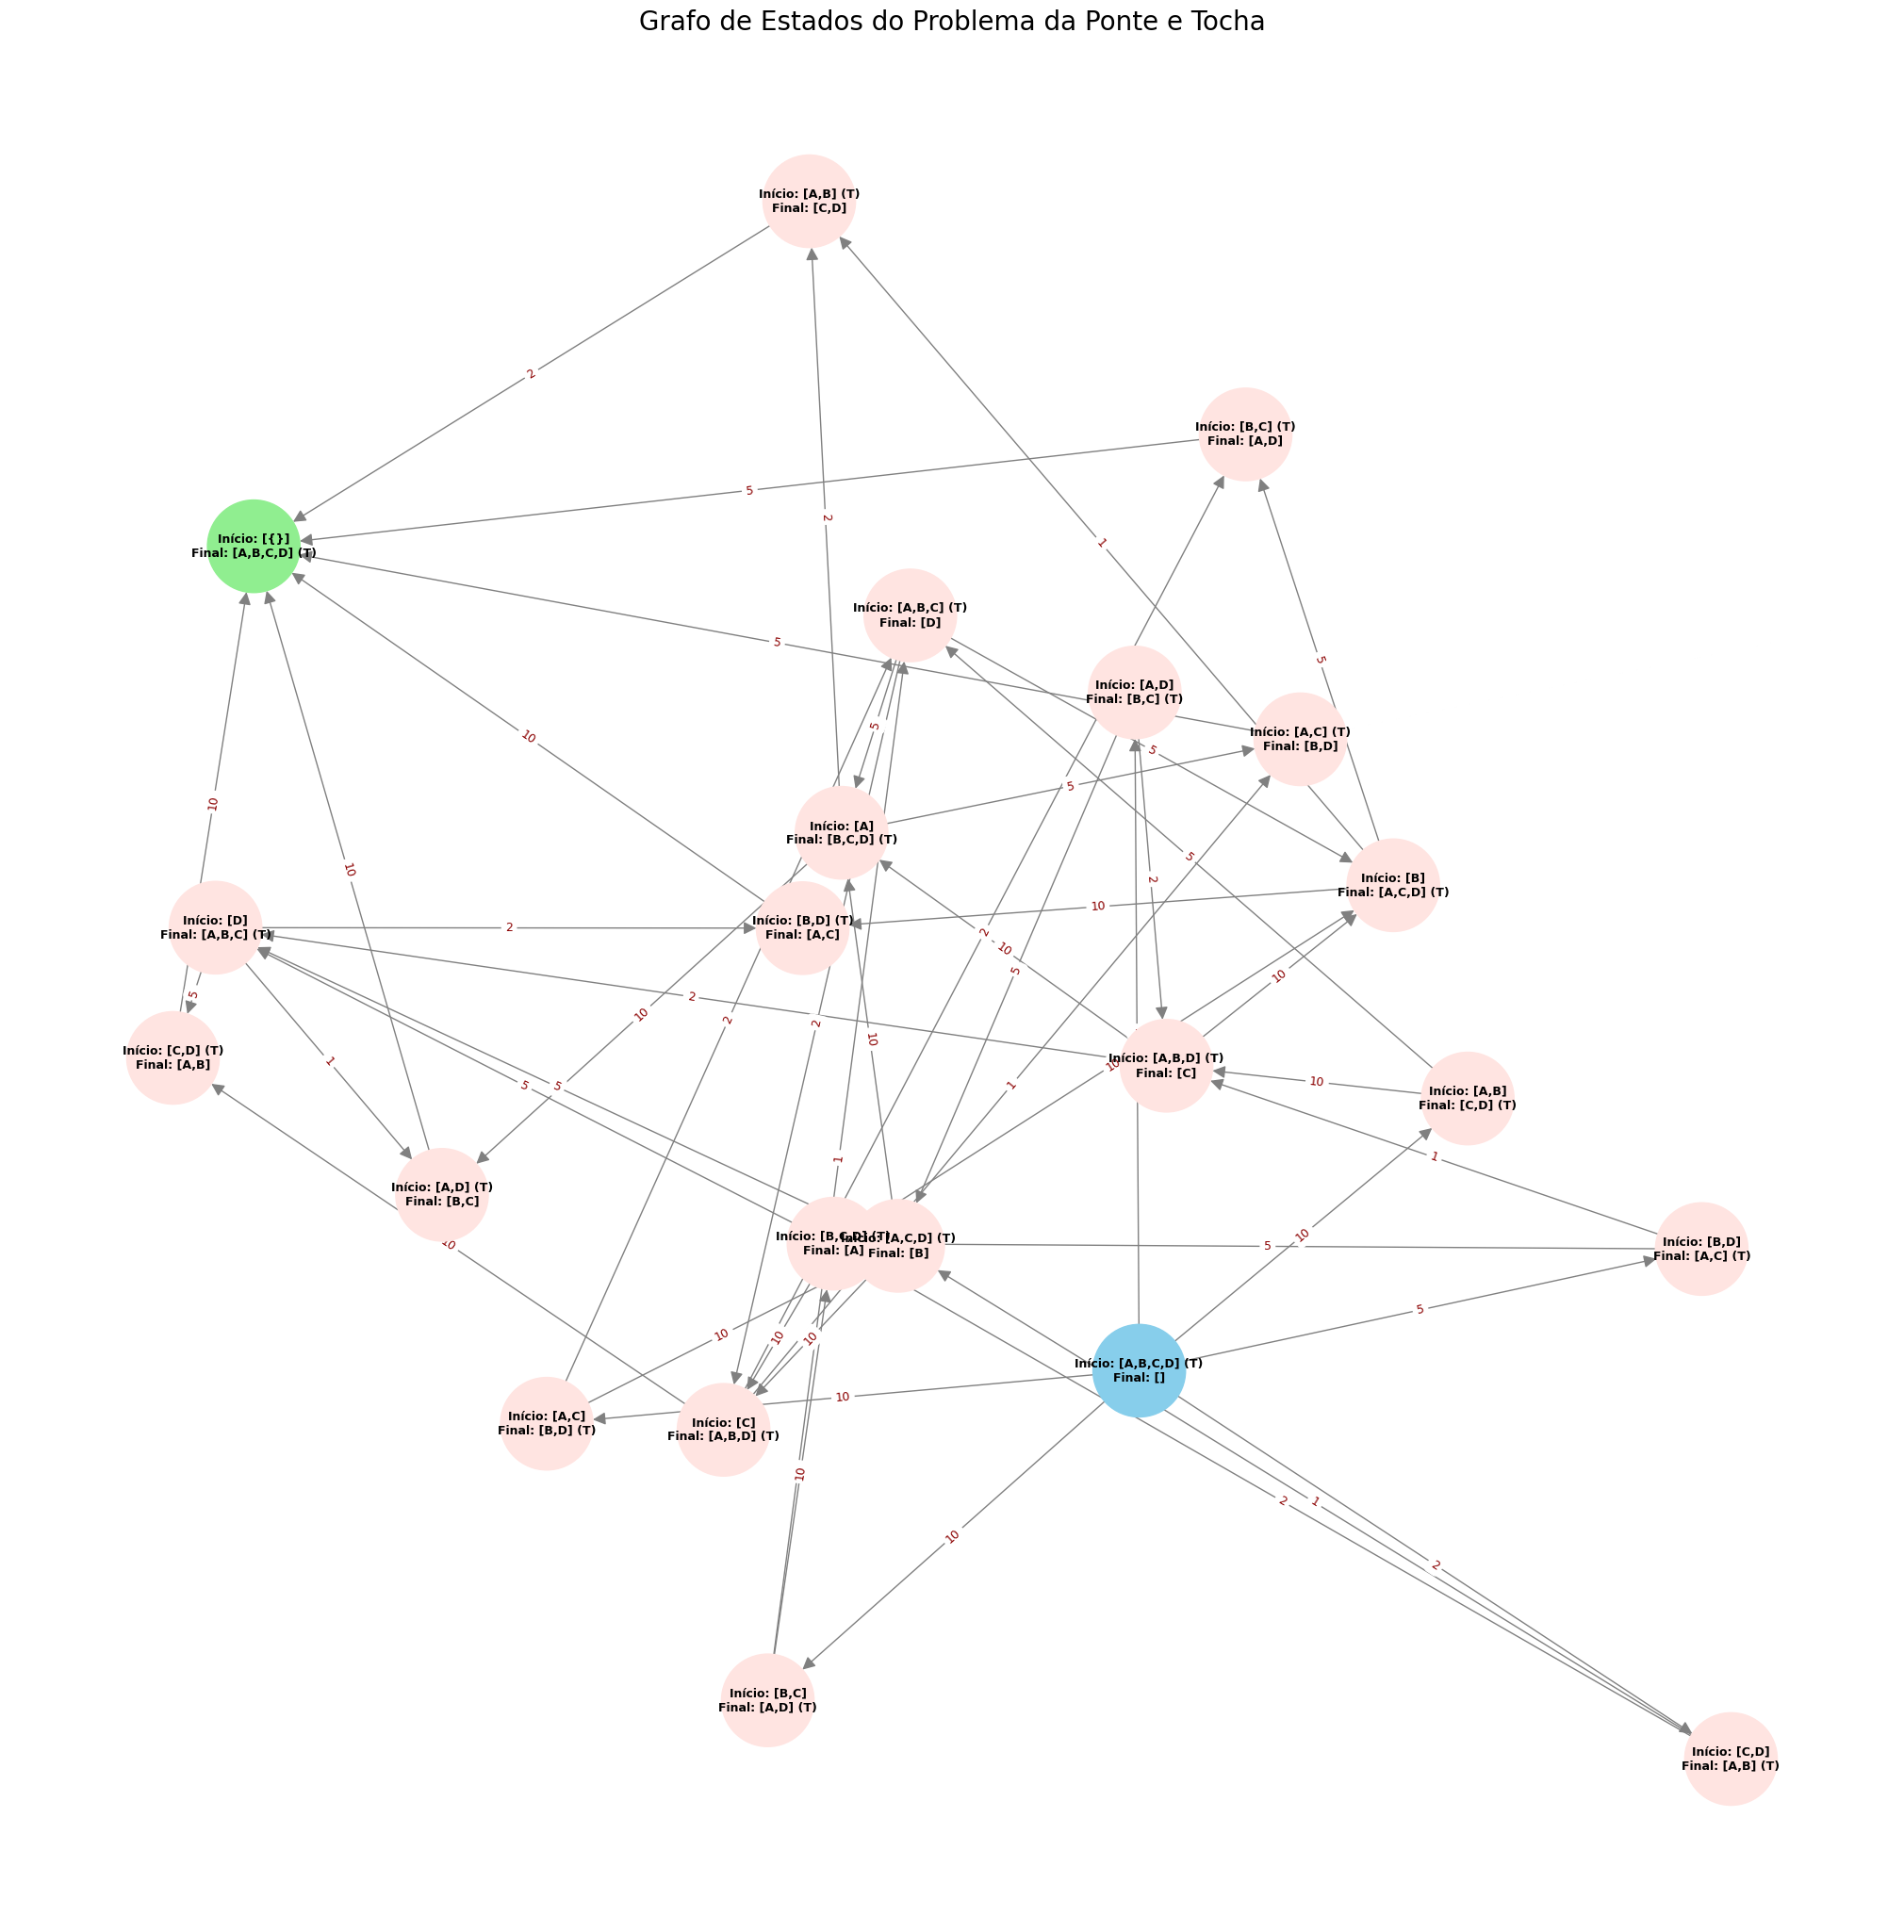

In [5]:
# Visualização do grafo de estados
print("\n=== Gerando Visualização do Grafo ===")
visualizar_grafo(grafo_completo, salvar_imagem=True)